In [0]:
from fastai.vision import *
from fastai import *

In [19]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
root_dir = "/content/gdrive/My Drive/"
gdrive_dir = root_dir + 'fastai/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:

num_classes = 2   # number of output classes discrete range [0,9]
num_epochs  = 20    # number of times the entire dataset is presented to the model
batch_size  = 4   # the size of input data took for one iteration
lr          = 1e-3 # size of step

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# **Data Extraction**

In [3]:
!wget "https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar"
!tar -xvf 'grid_version.tar'

--2020-01-22 18:32:17--  https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rl0qbub4clah2w9/grid_version.tar [following]
--2020-01-22 18:32:17--  https://www.dropbox.com/s/raw/rl0qbub4clah2w9/grid_version.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbea4e07a57caa925be6ad85fed.dl.dropboxusercontent.com/cd/0/inline/AwrVXJ2ZXifcPhjTgHfIbEPZJWqYCrZNFKBPXf1XTJPmB7_IFWNIz9q4SKw1A1X4xvcMEPb8FrilayfaFO_1X7fK_x6K9sLm0JhWpS0BOgBz9ySUILaIIc5ndHM20Ix_tn8/file# [following]
--2020-01-22 18:32:17--  https://ucbea4e07a57caa925be6ad85fed.dl.dropboxusercontent.com/cd/0/inline/AwrVXJ2ZXifcPhjTgHfIbEPZJWqYCrZNFKBPXf1XTJPmB7_IFWNIz9q4SKw1A1X4xvcMEPb8FrilayfaFO_1X7fK_x6K9sLm0JhWpS

In [0]:
train_input_folder ='grid_version/train'
validate_input_folder = 'grid_version/validate'

In [5]:
!ls grid_version/train


grid_no_smoke  grid_smoke


In [6]:
smoke_filenames = get_files(train_input_folder + '/grid_smoke')
no_smoke_filenames = get_files(train_input_folder + '/grid_no_smoke')
print(len(smoke_filenames),len(no_smoke_filenames))
smoke_img = open_image(smoke_filenames[0])
smoke_img.size

999 2622


torch.Size([170, 227])

In [0]:
tfms = get_transforms()
''''data = (ImageList
        .from_folder(train_input_folder,include=['grid_smoke','grid_no_smoke'])
        .split_by_rand_pct()
        .label_from_folder()
        .transform(tfms,size=(128,128))
        .databunch(bs=64)
        .normalize(imagenet_stats)
)'''

data = (ImageList.from_folder('grid_version')
        .split_by_folder(train='train', valid='validate')
        .label_from_folder()
        .transform(tfms,size=(128,128))
        .databunch(bs=64)
        .normalize(imagenet_stats)
       )

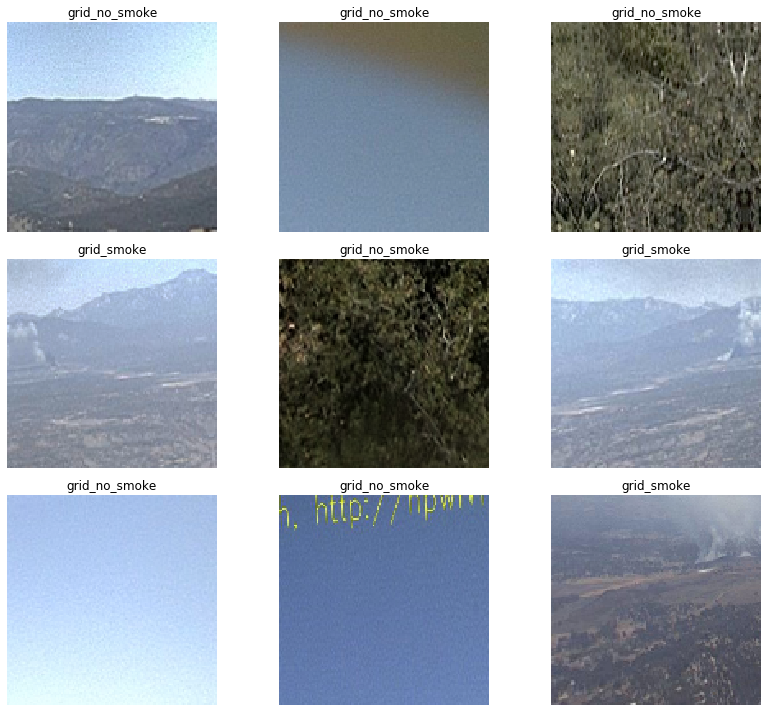

In [11]:
data.show_batch(rows=3,figsize=(12,10))

# **MODEL**

In [12]:
# loading imagenet pre-trained model, also using mix precision for training 
learn = cnn_learner(data,models.resnet34,metrics=[accuracy]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 137MB/s] 


In [0]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=True)
)

# **Training**

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


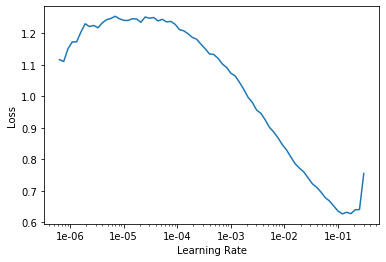

In [15]:
learn.recorder.plot()

In [16]:
lr = 3e-3
learn.fit_one_cycle(3,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.353316,0.020008,0.993648,00:25
1,0.151865,0.015269,0.994477,00:26
2,0.086207,0.010785,0.996962,00:26


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.98E-07


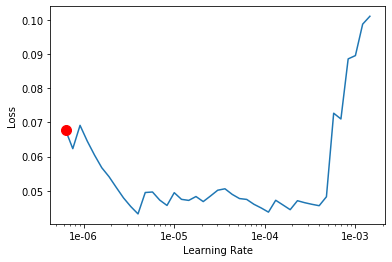

In [18]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.save('resnet34-stage-1-128')

In [20]:
learn.fit_one_cycle(5,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.042789,0.017779,0.996410,00:26
1,0.034742,0.018354,0.995857,00:26
2,0.025032,0.007340,0.998067,00:26
3,0.019556,0.002456,0.999171,00:25
4,0.013334,0.001968,0.999448,00:25


In [0]:
'''data_256 = (ImageList
        .from_folder(train_input_folder,include=['grid_smoke','grid_no_smoke'])
        .split_by_rand_pct()
        .label_from_folder()
        .transform(tfms,size=(256,256))
        .databunch(bs=64)
        .normalize(imagenet_stats)
)'''
data_256 = (ImageList.from_folder('grid_version')
        .split_by_folder(train='train', valid='validate')
        .label_from_folder()
        .transform(tfms,size=(256,256))
        .databunch(bs=64)
        .normalize(imagenet_stats)
       )

In [0]:
learn.data = data_256
learn.freeze_to(-1)
learn.to_fp16();

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.51E-06


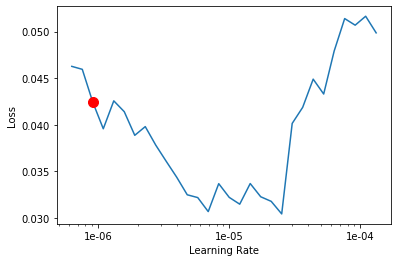

In [24]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [25]:
lr = 1e-6
learn.fit_one_cycle(3,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.053948,0.012407,0.995857,00:48
1,0.046889,0.013891,0.995305,00:47
2,0.051501,0.013287,0.995581,00:47


In [0]:
learn.unfreeze()

learn.save('res34-stage-1-256')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 2.51E-06


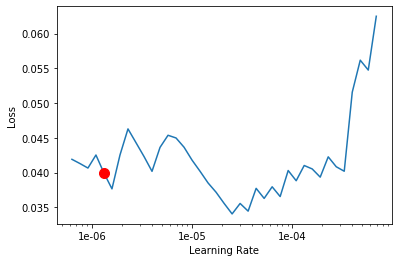

In [28]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [29]:
learn.fit_one_cycle(5,slice(1e-6,lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.051142,0.013023,0.995305,00:49
1,0.046365,0.011413,0.995857,00:48
2,0.033068,0.010121,0.996410,00:48
3,0.027777,0.011016,0.996686,00:48
4,0.026483,0.010452,0.995857,00:48


In [30]:
dest=Path(gdrive_dir+'/models/')
try:
  dest.mkdir(parents=True, exist_ok=False)
except FileExistsError:
  print ('File Already Exists')

learn.save(dest/'res34gridded-stage-2-256')
learn.export(file=dest/'res34gridded-stage-2-256.pkl')

File Already Exists


# **Predictions and Analysis(F1 score, ROC etc)**

In [31]:
y_p, y, loss = learn.get_preds(with_loss=True)

In [32]:
y_p.shape,y.shape

(torch.Size([3621, 2]), torch.Size([3621]))

In [0]:
pred = y_p.argmax(dim=-1).float()

In [34]:
pred.shape

torch.Size([3621])

In [35]:
from sklearn.metrics import f1_score
f1_score(y,pred)

0.9924509310518369

In [41]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(y_p[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9999557146773013


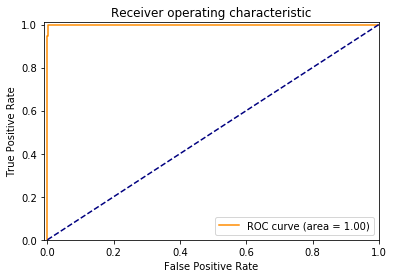

In [42]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

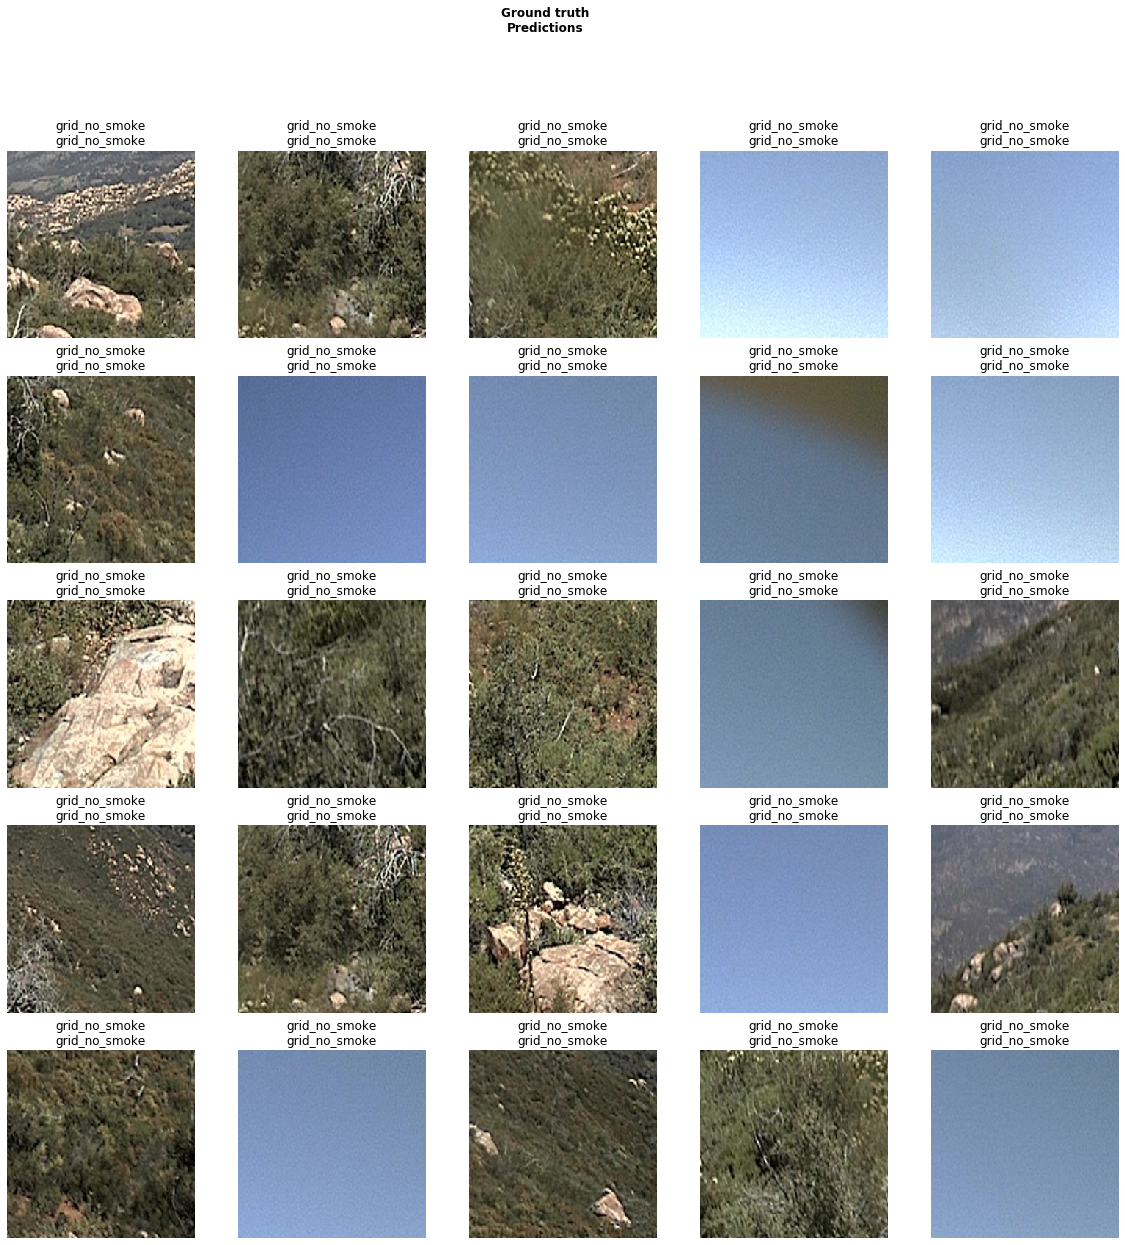

In [36]:
learn.show_results()

In [0]:
interp = ClassificationInterpretation(learn, y_p, y, loss)

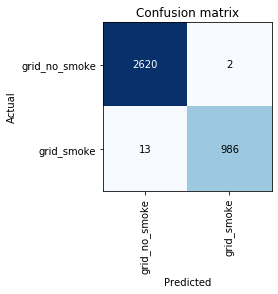

In [38]:
interp.plot_confusion_matrix()

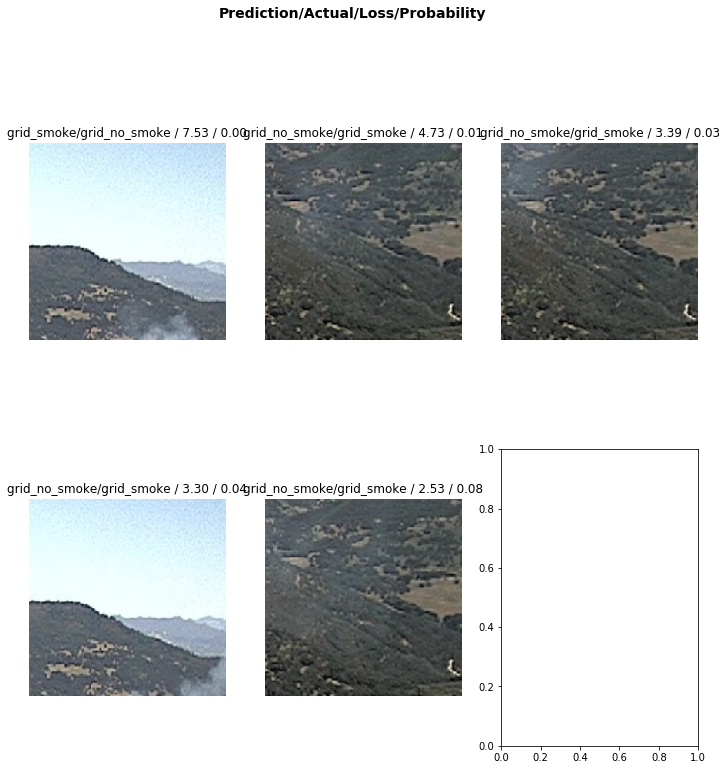

In [44]:
interp.plot_top_losses(5)